In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.robust.robust_linear_model import RLM

In [ ]:
# Loading the dataset
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_excel("/content/drive/MyDrive/Smallie/spark_dataset.xlsx")

Mounted at /content/drive


In [ ]:
# Selecting relevant columns for analysis
relevant_columns = df[['employees2017', 'employees2018', 'medicinsurance2017', 'pension2017', 'bsform2field2400']]

# Displaying the head of the selected data
print("First few rows of relevant data:\n", relevant_columns.head())

First few rows of relevant data:
    employees2017  employees2018  medicinsurance2017  pension2017  \
0          133.0          138.0          1576486.96  10913895.30   
1          166.0          168.0         13546589.77  44211488.57   
2          101.0          114.0          2123653.00   8933351.88   
3          295.0          238.0          5137599.07  21203783.18   
4          302.0          277.0          2368033.50  10559716.37   

   bsform2field2400  
0       -52314000.0  
1       192368000.0  
2         1526000.0  
3       -34261000.0  
4       -15016000.0  


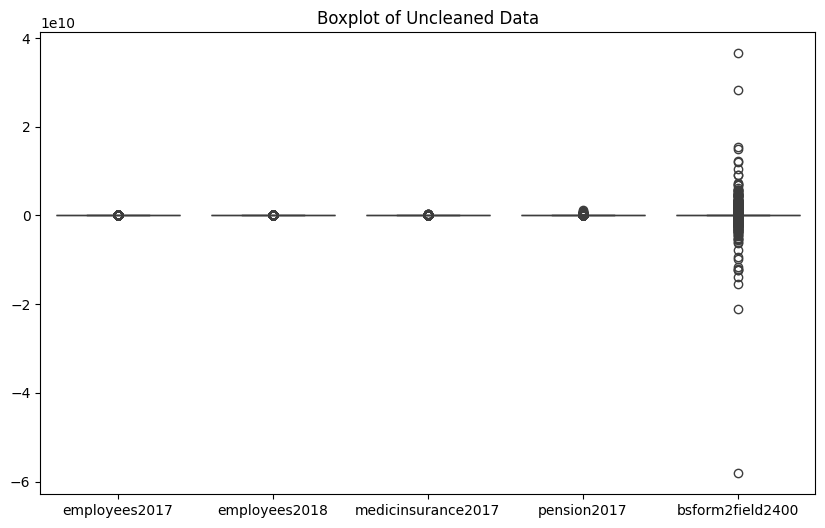

In [ ]:
# Boxplot of uncleaned data
plt.figure(figsize=(10, 6))
sns.boxplot(data=relevant_columns)
plt.title('Boxplot of Uncleaned Data')
plt.show()

In [ ]:
# Checking for missing values
print("\nMissing Values:\n", relevant_columns.isna().sum())


Missing Values:
 employees2017         1147
employees2018          709
medicinsurance2017     587
pension2017            366
bsform2field2400       102
dtype: int64


In [ ]:
# Dropping rows with missing values
cleaned_data = relevant_columns.dropna()
print("\nShape after dropping missing values:", cleaned_data.shape)
print("\nMissing Values:\n", cleaned_data.isna().sum())


Shape after dropping missing values: (192284, 5)

Missing Values:
 employees2017         0
employees2018         0
medicinsurance2017    0
pension2017           0
bsform2field2400      0
dtype: int64


In [ ]:
# Identifying outliers using the IQR method
Q1 = cleaned_data.quantile(0.25)
Q3 = cleaned_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers (instead of dropping them)
cleaned_data_capped = cleaned_data.copy()

# Capping the values at the lower and upper bounds
for col in cleaned_data.columns:
    cleaned_data_capped[col] = np.where(cleaned_data_capped[col] < lower_bound[col], lower_bound[col],
                                        np.where(cleaned_data_capped[col] > upper_bound[col], upper_bound[col],
                                                 cleaned_data_capped[col]))

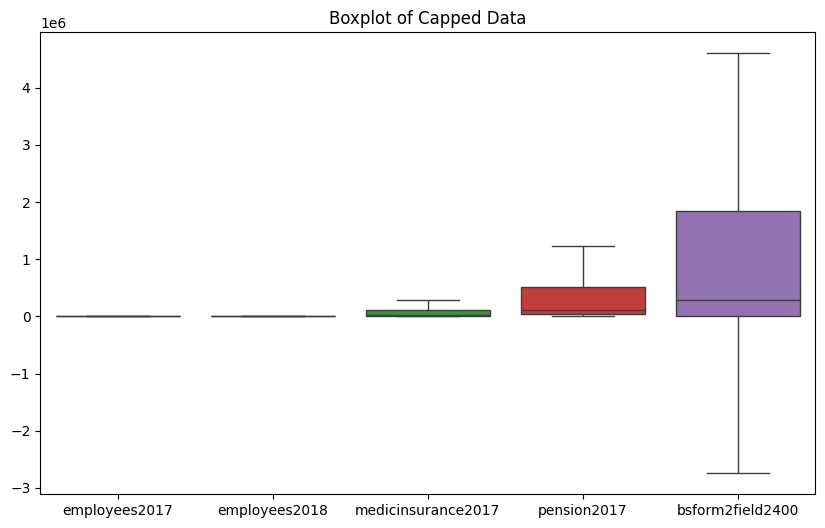

In [ ]:
# Boxplot after capping outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_data_capped)
plt.title('Boxplot of Capped Data')
plt.show()

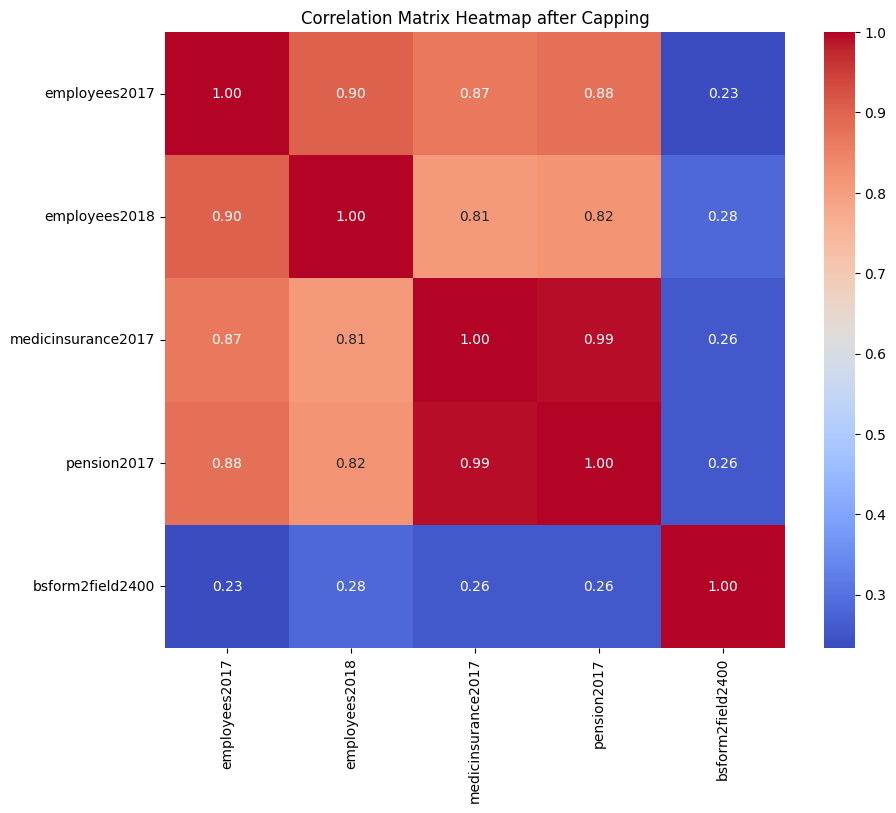

In [ ]:
# Correlation matrix after capping outliers
plt.figure(figsize=(10, 8))
sns.heatmap(cleaned_data_capped.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap after Capping")
plt.show()

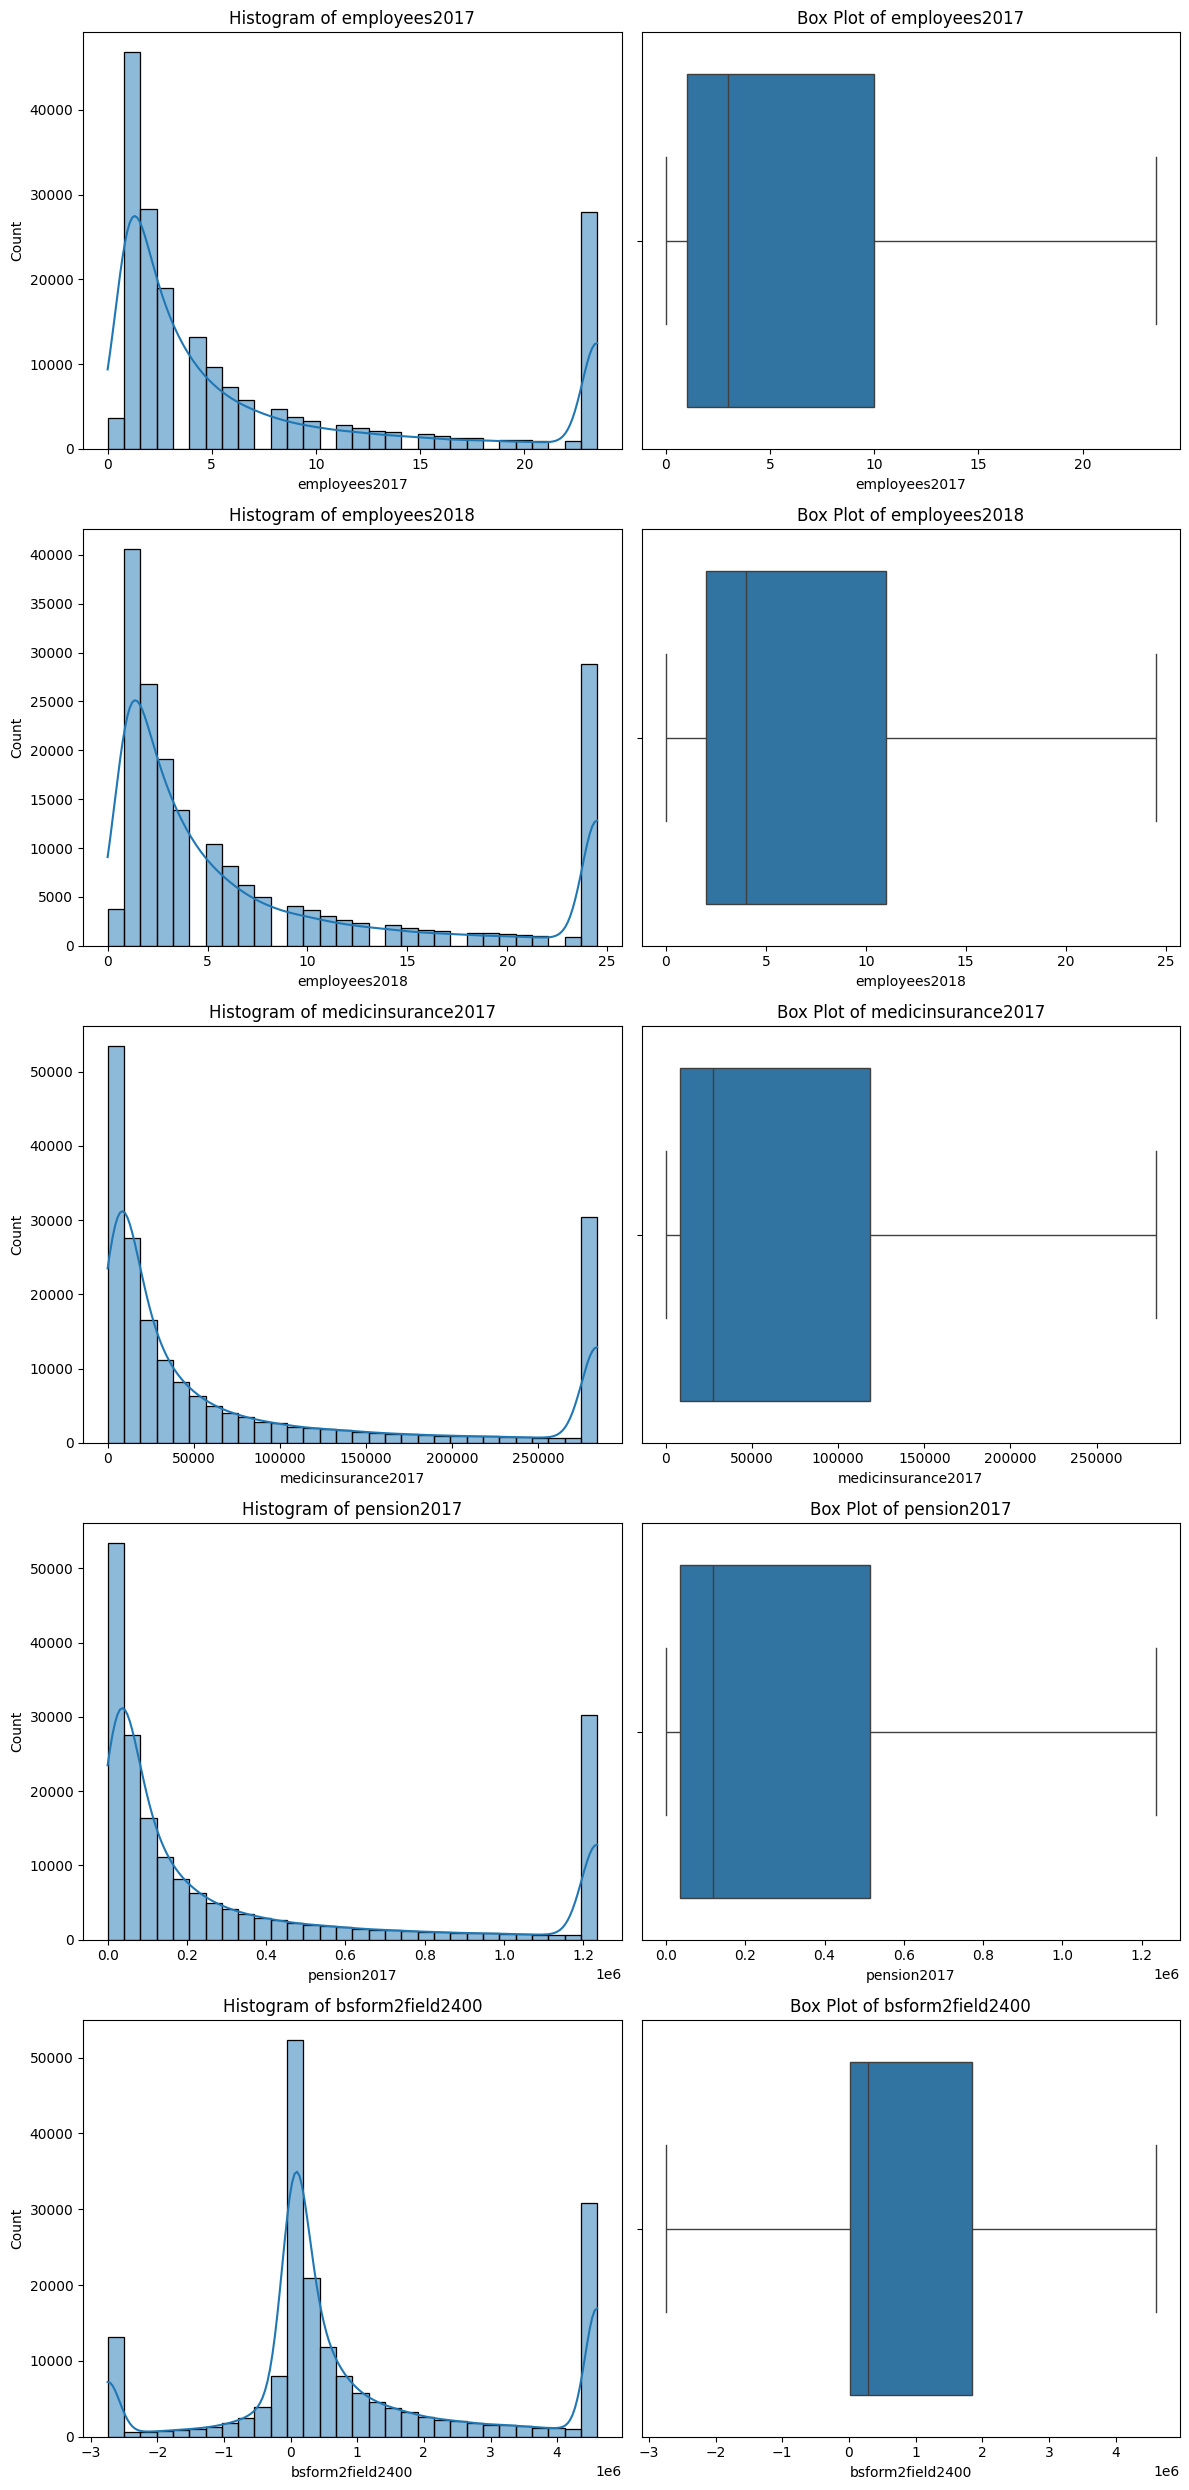

In [ ]:
# Histograms and Box Plots after capping outliers
fig, axs = plt.subplots(5, 2, figsize=(12, 25))

metrics = ['employees2017', 'employees2018', 'medicinsurance2017', 'pension2017', 'bsform2field2400']
for i, metric in enumerate(metrics):
    sns.histplot(cleaned_data_capped[metric], bins=30, kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Histogram of {metric}')

    sns.boxplot(x=cleaned_data_capped[metric], ax=axs[i, 1])
    axs[i, 1].set_title(f'Box Plot of {metric}')

plt.tight_layout()
plt.savefig('metrics_visualizations_with_pension_capped.png')
plt.show()

In [ ]:
# Regression Analysis
X = cleaned_data[['employees2017', 'employees2018', 'medicinsurance2017', 'pension2017']]
y = cleaned_data['bsform2field2400']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [ ]:
# Robust Standard Errors
model_robust = model.get_robustcov_results()
print("Regression Results with Robust SE:")
print(model_robust.summary())

Regression Results with Robust SE:
                            OLS Regression Results                            
Dep. Variable:       bsform2field2400   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.457
Date:                Fri, 27 Dec 2024   Prob (F-statistic):             0.0434
Time:                        13:47:47   Log-Likelihood:            -3.9762e+06
No. Observations:              192284   AIC:                         7.952e+06
Df Residuals:                  192279   BIC:                         7.952e+06
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
c

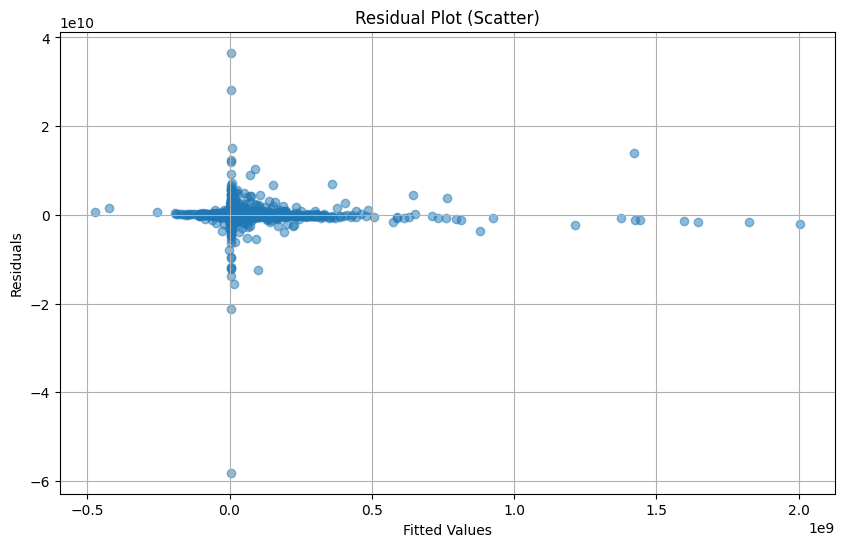

In [ ]:
# Residual Plot(Scatter)
fitted_values = model.predict(X)
residuals = model.resid

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.title('Residual Plot (Scatter)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [ ]:
# Conducting hypothesis testing for the regression coefficients
# Null hypothesis: The coefficient is equal to zero (no effect)
# Alternative hypothesis: The coefficient is not equal to zero (there is an effect)

# Extracting p-values from the regression summary
p_values = model.pvalues

# Creating a DataFrame to summarize the hypothesis testing results
hypothesis_testing_results = p_values.reset_index()

# Renaming the columns for clarity
hypothesis_testing_results.columns = ['Variable', 'P-Value']

# Displaying the hypothesis testing results
print(hypothesis_testing_results)

             Variable       P-Value
0               const  3.280032e-11
1       employees2017  1.348032e-17
2       employees2018  2.992893e-01
3  medicinsurance2017  1.108451e-48
4         pension2017  8.470599e-04


In [ ]:
# Confounding Variables and VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors (VIF):")
print(vif_data)

Variance Inflation Factors (VIF):
              feature        VIF
0               const   1.058195
1       employees2017   6.910092
2       employees2018   4.819109
3  medicinsurance2017  14.137098
4         pension2017  21.120579


In [ ]:
# Robust Linear Model
rlm_model = RLM(y, X).fit()
print("\nRobust Linear Model Regression Results:\n", rlm_model.summary())
print(f'R-squared: {model.rsquared}')
print(f'Adjusted R-squared: {model.rsquared_adj}')


Robust Linear Model Regression Results:
                     Robust linear Model Regression Results                    
Dep. Variable:       bsform2field2400   No. Observations:               192284
Model:                            RLM   Df Residuals:                   192279
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 27 Dec 2024                                         
Time:                        13:47:49                                         
No. Iterations:                    10                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------